# Lab Notebook 8 - SVM classification in particle physics

In this notebook we will learn about applying SVMs to a larger data set from particle physics.

_Data by [Sascha Caron](https://www.nikhef.nl/~scaron/). Modified from the Notebook by Viviana Acquaviva (2023). License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC # New algorithm!
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV # New! This will be used to explore different hyperparameter choices.

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)
rc('text', usetex=False)
plt.rc('font', size=15)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=16)
plt.rc('figure',figsize=(8,6))

## Step 1

Read in features and labels from 'ParticleID_features.csv' and 'ParticleID_labels.txt' using pandas. Read in labels from 'ParticleID_labels.txt'. Explore the data set to get an idea of what it looks like (ex: look at first few rows, shape, etc.).

In [3]:
features = pd.read_csv("ParticleID_features.csv")
pd.read_csv("ParticleID_features.csv")
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 68 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       5000 non-null   int64  
 1   MET      5000 non-null   float64
 2   METphi   5000 non-null   float64
 3   Type_1   5000 non-null   object 
 4   P1       5000 non-null   float64
 5   P2       5000 non-null   float64
 6   P3       5000 non-null   float64
 7   P4       5000 non-null   float64
 8   Type_2   4997 non-null   object 
 9   P5       4997 non-null   float64
 10  P6       4997 non-null   float64
 11  P7       4997 non-null   float64
 12  P8       4997 non-null   float64
 13  Type_3   4950 non-null   object 
 14  P9       4950 non-null   float64
 15  P10      4950 non-null   float64
 16  P11      4950 non-null   float64
 17  P12      4950 non-null   float64
 18  Type_4   4717 non-null   object 
 19  P13      4717 non-null   float64
 20  P14      4717 non-null   float64
 21  P15      4717 

In [4]:
labels = pd.read_csv("ParticleID_labels.txt", header=None, names=['Labels'])
pd.read_csv("ParticleID_labels.txt")

,ttbar
0,ttbar
1,ttbar
2,ttbar
3,ttbar
4,ttbar
...,...
4994,4top
4995,ttbar
4996,ttbar
4997,4top


## Step 2

The labels are in the form 'ttbar' and '4top'. Turn these categorical (string-type) labels into an array of zeros and ones, where 'ttbar'=0 and '4top'=1 using 'LabelEncoder' from sklearn.preprocessing. Call this new array "target".

In [5]:
le = LabelEncoder()
target= le.fit_transform(labels.values.ravel())
target = (target-1)*-1

## Step 3

Using describe() on features, look at the "count" row. Some columns only contain fractions of the total number of data set rows, due to the variable number of products in each collision

In [6]:
features.describe()

,ID,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52
count,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4.950000e+03,4950.000000,4950.000000,4950.000000,4.717000e+03,4717.000000,4717.000000,4717.000000,4.002000e+03,4002.000000,4002.000000,4002.000000,2.871000e+03,2871.00000,2871.000000,2871.000000,1.889000e+03,1889.000000,1889.000000,1889.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,7.290000e+02,729.000000,729.000000,729.000000,4.420000e+02,442.000000,442.000000,442.000000,2.610000e+02,261.000000,261.000000,261.000000,1.270000e+02,127.000000,127.000000,127.000000,5.600000e+01,56.000000,56.000000,56.000000
mean,2499.500000,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.527799e+05,1.080302e+05,-0.029936,0.007327,2.117980e+05,74863.343131,-0.025104,0.011845,1.805997e+05,57289.049481,0.010723,0.045266,1.780366e+05,48798.018516,0.015167,-0.031312,1.705620e+05,44042.67015,-0.022948,0.014522,1.628825e+05,41151.069666,0.002228,0.006738,1.581409e+05,40250.387015,0.072349,-0.035907,1.596814e+05,40139.289849,0.061654,-0.045868,1.574039e+05,39703.038235,0.118543,0.024249,1.561160e+05,38173.716092,0.029455,0.026422,1.631051e+05,34876.849606,0.206978,-0.001085,1.456600e+05,36151.183929,-0.000879,0.219260
std,1443.520003,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638580e+05,8.136261e+04,1.439105,1.828832,2.510361e+05,46309.512365,1.577316,1.802715,2.383403e+05,32013.857623,1.634072,1.812078,2.577958e+05,26252.978520,1.744489,1.784248,2.381745e+05,23510.65367,1.806611,1.811101,2.269341e+05,20988.953157,1.815312,1.771888,2.118782e+05,26556.025657,1.836492,1.796932,2.308620e+05,30074.756789,1.842798,1.788596,2.165489e+05,30502.312276,1.872084,1.826435,2.319016e+05,29324.658352,1.884750,1.753017,2.248603e+05,20433.767238,1.998859,1.949004,1.943657e+05,25861.883410,1.941707,1.910400
min,0.000000,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,1.087540e+04,1.080000e+04,-4.668790,-3.140530,1.221050e+04,10639.800000,-4.520250,-3.141480,1.169190e+04,10818.000000,-4.616550,-3.136130,1.110310e+04,10287.000000,-4.778980,-3.139040,1.070330e+04,10066.90000,-4.930230,-3.140380,1.197700e+04,11260.200000,-4.758150,-3.135630,1.380860e+04,10973.300000,-4.606330,-3.132610,1.119760e+04,10067.900000,-4.814380,-3.136380,1.615530e+04,10183.700000,-4.803880,-3.135910,2.004750e+04,14800.200000,-4.400470,-3.130690,1.780380e+04,12987.900000,-4.447660,-3.139820,2.512510e+04,14836.000000,-4.448760,-2.990730
25%,1249.750000,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007510e+05,6.321840e+04,-1.060500,-1.602460,7.636905e+04,46549.475000,-1.125620,-1.547418,5.999090e+04,36097.700000,-1.121240,-1.518030,5.278370e+04,30891.650000,-1.198468,-1.550615,5.007050e+04,28453.95000,-1.250050,-1.586675,4.695560e+04,27963.500000,-1.231420,-1.475380,4.535515e+04,27140.550000,-1.243962,-1.626688,4.387110e+04,26825.000000,-1.226980,-1.513330,4.410735e+04,26589.250000,-1.223240,-1.422415,4.092160e+04,25298.300000,-1.413650,-1.270700,4.365005e+04,24742.500000,-1.259230,-1.817600,4.112588e+04,24974.125000,-1.243362,-1.490900
50%,2499.500000,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.659740e+05,8.584360e+04,-0.057428,0.015111,1.288565e+05,62498.400000,-0.040648,0.034238,9.922610e+04,48949.200000,-0.035512,0.060279,9.206885e+04,41054.850000,0.054393,-0.079641,8.593460e+04,37378.30000,-0.046667,0.040528,7.975460e+04,34681.700000,0.025305,0.046141,8.315485e+04,33683.550000,0.156083,-0.015617,7.894980e+04,33328.000000,0.072709,-0.052590,7.609735e+04,30942.700000,0.035675,0.090282,7.568430e+04,29479.700000,-0.088908,-0.041002,8.050910e+04,28262.800000,0.120301,-0.232455,9.553645e+04,27353.550000,-0.121213,0.128103
75%,

Therefore, we will consider a subset of the data, so we have limited imputing/manipulation problems. Define "features_lim" as the new limited data set: it only contains the columns 

'MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', and 'P16'
       
There may still be some columns with NaN values, so replace NaN with 0 for the moment.

In [7]:
features_lim = features[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15','P16']]

In [8]:
features_lim = features_lim.fillna(0)

**Note:** replacing NaN with 0 is the simplest but worst possible choice - imputing a constant value skews the model. One step up would be to input the mean or median for each column. However, because only a limited number of instances have missing data, the choice of imputing strategy doesn't matter too much.

Use "describe()" to confirm that the count is the same for all features:

In [9]:
features_lim.describe()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.526283e+05,1.079653e+05,-0.029918,0.007323,2.096800e+05,74114.709700,-0.024853,0.011727,1.703778e+05,54046.489280,0.010116,0.042704
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638514e+05,8.138121e+04,1.438673,1.828283,2.506651e+05,46675.655162,1.569410,1.793678,2.352279e+05,33795.723384,1.587146,1.760070
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,0.000000e+00,0.000000e+00,-4.668790,-3.140530,0.000000e+00,0.000000,-4.520250,-3.141480,0.000000e+00,0.000000,-4.616550,-3.136130
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007050e+05,6.320943e+04,-1.059270,-1.599617,7.488228e+04,46165.375000,-1.108390,-1.532478,5.480870e+04,33959.400000,-1.050477,-1.424080
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.658985e+05,8.581595e+04,-0.056810,0.012737,1.277135e+05,62167.100000,-0.023321,0.006687,9.259335e+04,47278.800000,0.000000,0.000000
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999058e+05,1.238520e+05,1.028055,1.601880,2.406498e+05,89065.300000,1.048617,1.553310,1.831228e+05,66846.300000,1.085627,1.521765
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,2.800410e+06,788338.000000,4.798090,3.139020,2.503590e+06,481884.000000,4.730480,3.139660


## Step 4: labels and benchmarking

What percentage of the data has the negative label (0) versus the positive label (1)? What is the accuracy of a classifier that puts everything in the negative class?

In [35]:
percentage_neg = (len(target) - np.sum(target))/len(target)
percentage_pos = np.sum(target)/len(target)

print("Negative label (0):", percentage_neg)
print("Positve label (1):", percentage_pos)

print("Accuracy of a classifier putting everything in the negative class:",percentage_neg)

Negative label (0): 0.8378
Positve label (1): 0.1622
Accuracy of a classifier putting everything in the negative class: 0.8378


For contrast, a random classifier that just assigns a random value according to class distribution has the following accuracy:

### - A random classifer would assign random values baised on the class distribution, so the accuracy would be the same of the percentage of the negative label.

## Step 5: Let's start with a linear model; model = LinearSVC()

1. Define a benchmark linear model, "bmodel", using LinearSVC(dual=False).

2. Use "StratifiedKFold" with 5 splits, shuffle set to True, and a random state of 101 to produce a cross-validation object, "cv".

3. Run "cross_validate", where scoring = 'accuracy' and return_train_score=True. This will output the fit time, the score time, the test score, and the train score. Print these.

4. Print the mean and standard deviation of the test_score.

In [11]:
bmodel = LinearSVC(dual=False)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

In [12]:
scores = cross_validate(bmodel, features_lim, target, scoring='accuracy', cv=cv, return_train_score=True)

print("Fit Time:", scores['fit_time'])
print("Score Time:", scores['score_time'])
print("Test Score:", scores['test_score'])
print("Train Score:", scores['train_score'])

mean_test_score = scores['test_score'].mean()
std_test_score = scores['test_score'].std()

print("\nMean Test Score:", mean_test_score)
print("Standard Deviation of Test Score:", std_test_score)

Fit Time: [0.23280621 0.0153234  0.01566195 0.01557994 0.02520585]
Score Time: [0.03154564 0.         0.         0.         0.00120687]
Test Score: [0.841 0.825 0.829 0.83  0.833]
Train Score: [0.8315  0.83275 0.8315  0.83125 0.832  ]

Mean Test Score: 0.8316000000000001
Standard Deviation of Test Score: 0.005351635264103866


## Step 6

Technically, standardizing/normalizing data using the entire learning set introduces leakage between train and test set (the test set "knows" about the mean and standard deviation of the entire data set). Usually this is not a dramatic effect, but the correct procedure is to derive the scaler within each CV fold (i.e. after separating in train and test), only on the train set, and apply the same transformation to the test set. The model then becomes a pipeline.

Similar to lab 5-6, set up a pipeline with StandardScaler and LinearSVC(dual=False,C=1000), use it in cross_validate and report the results. For the test and train scores, print the mean and standard deviation:

In [13]:
model = Pipeline([('scaler', StandardScaler()),('classifier', LinearSVC(dual=False, C=1000))])

scores_norm = cross_validate(model, features_lim, target, scoring='accuracy', cv=cv, return_train_score=True)

print("Fit Time:", scores_norm['fit_time'])
print("Score Time:", scores_norm['score_time'])
print("Test Score:", scores_norm['test_score'])
print("Train Score:", scores_norm['train_score'])

print("\nMean Test Score:", scores_norm['test_score'].mean())
print("Standard Deviation of Test Score:", scores_norm['test_score'].std())

Fit Time: [0.00554895 0.00797772 0.00836325 0.00051498 0.01554894]
Score Time: [0.00805259 0.0023644  0.00239611 0.         0.        ]
Test Score: [0.894 0.889 0.89  0.892 0.899]
Train Score: [0.89575 0.895   0.895   0.89825 0.89275]

Mean Test Score: 0.8928
Standard Deviation of Test Score: 0.0035440090293338733


For the test and train scores of benchmark_lim_piped, print the mean and standard deviation:

In [14]:
print("Mean Test Score:", scores_norm['test_score'].mean())
print("Standard Deviation of Test Score:", scores_norm['test_score'].std())
print("\nMean Train Score:", scores_norm['train_score'].mean())
print("Standard Deviation of Train Score:", scores_norm['train_score'].std())

Mean Test Score: 0.8928
Standard Deviation of Test Score: 0.0035440090293338733

Mean Train Score: 0.89535
Standard Deviation of Train Score: 0.0017649362594722646


This should show a significant improvement, and the comparison between test and train scores tells us already something about the problem that we have. We can formalize this by looking at the learning curves, which tell us both about gap between train/test scores, AND whether we need more data.

## Step 7: Learning Curves

As in lab 5-6, construct the learning curve (you can recycle code). What does it tell you? 

### It tells us how well this particular algorithm and hyperparamters suffer from a varience error or a bias error.

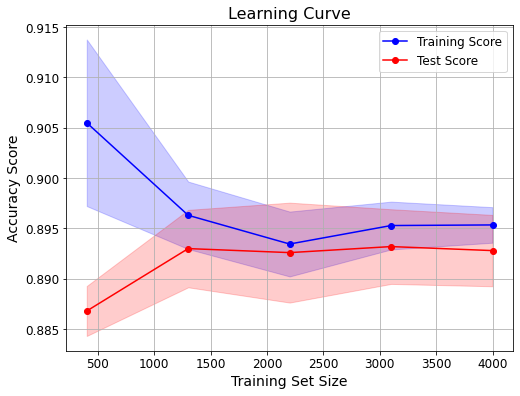

In [15]:
train_sizes, train_scores, test_scores = learning_curve(model, features_lim, target, cv=cv, scoring='accuracy', n_jobs=-1)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, test_mean, label='Test Score', color='red', marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

Is there anything we can conclude from this graph?

## We can conclude for this particular graph that 1) adding more data would not help, 2) our model does not suffer from high varience, as there is a small difference between the training score and the test score. Any steps to improve would go towards solving high bias.

## Step 8: Parameter optimization via cross-validation

When we optimize parameters with a grid search, we choose the parameters that give the best test scores. This is different from what would happen with new data - to do this fairly, at no point of the training procedure we are allowed to look at the test labels. Therefore, we would need to do <b> nested cross validation </b> to avoid leakage between the parameter optimization and the cross validation procedure and properly evaluate the generalization error. For now, we are just looking for the best model so "simple" CV is sufficient.

In [16]:
# Given:
piped_model = make_pipeline(StandardScaler(), SVC()) #now using the general SVC so I can change the kernel
piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

We can define a dictionary of parameter values to run the optimization. 

Note that this might take awhile (5-15 minutes); the early estimates output by this cell may be misleading because more complex models (in particular high gamma) take longer.

Once you run this cell, the "model" object will have attributes "best_score_", "best_params_" and "best_estimator_", which give us access to the optimal estimator (printed out), as well as "cv_results_" that can be used to visualize the performance of all models.

In [17]:
# Given:
%time
#optimizing SVC: THIS IS NOT YET NESTED CV

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':['scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0], \
              'svc__degree': [2, 4]}

model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 4, n_jobs = -1, return_train_score=True)

model.fit(features_lim,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params, best score: 0.8964 {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


## Step 9

Next, we visualize the models in a pandas data frame, and rank them according to their test scores.

You may find it useful to look at: 
1. the mean and std of the test scores
2. the mean of the train scores (to evaluate if they differ and the significance of the result)
3. fitting time (we can pick a faster model instead of the best model if the scores are comparable)!

Let "scores_lim" be the dataframe containing "model.cv_results_". Print the columns.

In [18]:
scores_lim = pd.DataFrame(model.cv_results_)
print('Columns of score_lim:',scores_lim.columns )

Columns of score_lim: Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_svc__C', 'param_svc__degree', 'param_svc__gamma',
       'param_svc__kernel', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')


Next, in "scores_lim", sort the columns 'params','mean_test_score','std_test_score','mean_train_score', and 'mean_fit_time' by descending 'mean_test_score':

In [19]:
sorted_scores = scores_lim.sort_values(by='mean_test_score', ascending=False)[['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'mean_fit_time']]
print(sorted_scores)

                                                                               params  \
13     {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}   
19     {'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}   
33       {'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}   
27       {'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}   
15        {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}   
21        {'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}   
17         {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}   
23         {'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}   
45      {'svc__C': 100.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}   
39      {'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}   
25    {'svc__C': 10.0

To build some intuition around the results, I find it helpful to ask: what hyperparameter values are common to all the best-performing models? Here, for example, the rbf kernel seems to be constantly preferred, while the values of C and gamma seem to only affect the scores only mildly. Note also that the Grid Search is insensitive to moot parameters combinations; for example, here the first three models are identical, because the degree of the polynomial kernel does not matter when using an rbf kernel. This is less than ideal, of course.

### Final diagnosis 

The problem here is high bias, which is not that surprising given that we are using only a subset of features.

We can try two things: making up new features which might help, based on what we know about the problem, and using an imputing strategy to include information about the discarded features.

### Step 10: Improve the model. 

In order to include additional features, use .fillna(0) to replace all nan with zero, and .replace('',0) to replace empty string values. Check the result.

In [20]:
features_lim = features_lim.fillna(0).replace('', 0)
print(features_lim.head()) 

       MET    METphi        P1        P2        P3        P4        P5  \
0  62803.5 -1.810010  137571.0  128444.0 -0.345744 -0.307112  174209.0   
1  57594.2 -0.509253  161529.0   80458.3 -1.318010  1.402050  291490.0   
2  82313.3  1.686840  167130.0  113078.0  0.937258 -2.068680  102423.0   
3  30610.8  2.617120  112267.0   61383.9 -1.211050 -1.457800   40647.8   
4  45153.1 -2.241350  178174.0  100164.0  1.166880 -0.018721   92351.3   

         P6        P7        P8        P9      P10       P11       P12  \
0  127932.0  0.826569  2.332000   86788.9  84554.9 -0.180795  2.187970   
1   68462.9 -2.126740 -2.582310   44270.1  35139.6 -0.706120 -0.371392   
2   54922.3  1.226850  0.646589   60768.9  36244.3  1.102890 -1.434480   
3   39472.0 -0.024646 -2.222800  201589.0  32978.6 -2.496040  1.137810   
4   69762.1  0.774114  2.568740   61625.2  50086.7  0.652572 -3.012800   

        P13      P14      P15       P16  
0  140289.0  76955.8 -1.19933 -1.302800  
1   72883.9  26902.2 -1.65

#### Let's start by looking at what kind of particles we have as a product of the collision.

In [21]:
np.unique(np.array([features['Type_'+str(i)].values for i in range(1,14)]).astype('str'))

array(['b', 'e+', 'e-', 'g', 'j', 'm+', 'm-', 'nan'], dtype='<U3')

#### Here are the proposed new features (justification can be found in Chapter 4).
    
    1. The total number of particles produced
    2. The total number of b jets
    3. The total number of jets
    4. The total number of leptons (electrons, positron, mu+, mu-)

In [22]:
#count number of non-zero types 
ntot = np.array([-(np.sum(np.array([features['Type_'+str(i)].values[j] == 0 for i in range(1,14)])) - 13) for j in range(features.shape[0])])

In [23]:
#count number of b jets 
nbtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'b' for i in range(1,14)])) for j in range(features.shape[0])])

In [24]:
#Actually, let's count all types (jets, photons g, e-, e+, mu-, mu+)
njtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'j' for i in range(1,14)])) for j in range(features.shape[0])])

In [25]:
ngtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'g' for i in range(1,14)])) for j in range(features.shape[0])])

In [26]:
n_el_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e-' for i in range(1,14)])) for j in range(features.shape[0])])

In [27]:
n_pos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e+' for i in range(1,14)])) for j in range(features.shape[0])])

In [28]:
n_muneg_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm-' for i in range(1,14)])) for j in range(features.shape[0])])

In [29]:
n_mupos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm+' for i in range(1,14)])) for j in range(features.shape[0])])

In [30]:
n_lepton_tot = n_el_tot + n_pos_tot + n_muneg_tot + n_mupos_tot

Add these new features to the dataset and check the result. How many features are there now?

In [31]:
features["ntot"]=ntot
features["nbtot"]=nbtot
features["njtot"]=njtot
features["ngtot"]=ngtot
features["n_lepton_tot"]=n_lepton_tot

In [32]:
features.shape
print("Number of features:",features.shape[1] )

Number of features: 73


### Feature engineering: impact of ad-hoc variables

Define 'features_lim_2' as the original 'features_lim' plus the new five hand-crafted features. Apply the piped model (StandardScaler plus LinearSVC) to this new dataset via cross_validate. Compute the mean and standard deviation of the test scores. Any improvements?

In [33]:
new_features = features[["ntot","nbtot", "njtot", "ngtot","n_lepton_tot"]]
features_lim_2 = pd.concat([features_lim, new_features], axis=1)

In [34]:
model = Pipeline([('scaler', StandardScaler()),('classifier', LinearSVC(dual=False, C=1000))])

scores_norm = cross_validate(model, features_lim_2, target, scoring='accuracy', cv=cv, return_train_score=True)

print("Mean Test Score:", scores_norm['test_score'].mean())
print("Standard Deviation of Test Score:", scores_norm['test_score'].std())

Mean Test Score: 0.9480000000000001
Standard Deviation of Test Score: 0.008124038404635967


## - There was an improvement in the test score and it was a lot quicker

Note: Knowledge-informed feature engineering is often very successful, more than hyperparameter optimization. Machine learning methods are often tooted for their ability to learn relevant representations, but non-deep-learning methods are less capable to do so, and providing informative features is very helpful.

We can optimize this model as well; it will take a while, just like the previous time.

In [184]:
%time
#optimizing SVC: Takes a few minutes!
piped_model = make_pipeline(StandardScaler(), SVC())

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':['scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0], 'svc__degree': [2, 4, 8]}

nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = -1, return_train_score=True)
model.fit(features_lim_2,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

CPU times: user 3 µs, sys: 7 µs, total: 10 µs
Wall time: 6.91 µs
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params, best score: 0.9446 {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### Take-home message: feature engineering often works best if we use subject matter knowledge, and building more features is not necessarily better.